In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline

In [2]:
import time

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [4]:
!echo $CUDA_VISIBLE_DEVICES

0


## Get the data

This is the simulated data used in the DeepLIFT paper. The the pwms for the GATA motif and TAL motif (GATA_disc1 and TAL1_known1 from http://compbio.mit.edu/encode-motifs/) are used to generate motifs which are inserted into a random background. Sequences containing at least one GATA motif are a 1 for task 1, 0 otherwise. Sequences containing at least one TAL motif are a 1 for task 2, 0 otherwise. Sequences containing both a TAL and a GATA motif are a 1 for task 0. 

In [5]:
!ls ctcf_data

train_data.hdf5  valid_data.hdf5


In [6]:
import h5py
import numpy as np
onehot_train = np.array(h5py.File("ctcf_data/train_data.hdf5")['X']['sequence'][:,300:700,:])
onehot_test = np.array(h5py.File("ctcf_data/valid_data.hdf5")['X']['sequence'][:,300:700,:])
print(onehot_train.shape)
print(onehot_test.shape)
labels_train = np.array(h5py.File("ctcf_data/train_data.hdf5")['Y']['output'][:,0], dtype=int)
labels_test = np.array(h5py.File("ctcf_data/valid_data.hdf5")['Y']['output'][:,0], dtype=int)
print(labels_train.shape)
print(labels_test.shape)

(3971, 400, 4)
(6430, 400, 4)
(3971,)
(6430,)


In [7]:
print(labels_train)
print(np.sum(labels_train))
print(labels_test)
print(np.sum(labels_test))
print(onehot_train.shape[0])

[0 0 0 ..., 0 0 0]
446
[0 0 0 ..., 0 0 0]
908
3971


In [8]:
background_indices = np.nonzero(labels_train==0)[0]
print(background_indices)
print(background_indices.shape)

[   0    1    2 ..., 3968 3969 3970]
(3525,)


## Compute the gapped kmer embeddings

We will compute the embeddings using the GPU to scan for matches to the gapped kmers, allowing for some numbed of mismatches. First, we will prepare the function that is going to do our scanning on the GPU.

In [9]:
import ssvmimp
import ssvmimp.train

max_mismatches=0

start = time.time()
filters, string_reps, embedding_func = ssvmimp.train.get_gapped_kmer_embedding_filters_and_func(
                                kmer_len=6, alphabet=['A','C','G','T'],
                                num_gaps=1, max_mismatches=max_mismatches)
print("Filters,Embedding func computed in:", round(time.time() - start, 2), "s")

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN not available)


Filters,Embedding func computed in: 0.69 s


'string_reps' stores string representations of the filters, as shown below (gaps are indicated with whitespace):

In [10]:
print("Number of filters:",len(string_reps))
print("First ten filters:")
print("\n".join(string_reps[:10]))
print("Last ten filters:")
print("\n".join(string_reps[-10:]))

Number of filters: 5120
First ten filters:
AAAAA 
AAAAC 
AAAAG 
AAAAT 
AAACA 
AAACC 
AAACG 
AAACT 
AAAGA 
AAAGC 
Last ten filters:
T TTCG
T TTCT
T TTGA
T TTGC
T TTGG
T TTGT
T TTTA
T TTTC
T TTTG
T TTTT


Now, we compute the embeddings, which are the sum of the number of matches to each filter per sequence, accounting for the desired number of mismatches

In [11]:
start = time.time()
embeddings = embedding_func(onehot=onehot_train, batch_size=20, progress_update=500)
print("Embeddings computed in:", round(time.time() - start, 2), "s")
print("Shape of the embeddings matrix:",embeddings.shape)

Done 0
Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Embeddings computed in: 2.49 s
Shape of the embeddings matrix: (3971, 5120)


In [12]:
start = time.time()
test_embeddings = embedding_func(onehot=onehot_test, batch_size=20, progress_update=500)
print("Test embeddings computed in:", round(time.time() - start, 2), "s")
print("Shape of the test embeddings matrix:",test_embeddings.shape)

Done 0
Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500
Done 5000
Done 5500
Done 6000
Test embeddings computed in: 3.91 s
Shape of the test embeddings matrix: (6430, 5120)


Limit features to gkmers that are statistically overrepresented in the positive set

In [13]:
train_set_num = onehot_train.shape[0] 
train_embeddings = embeddings[:train_set_num]
kmer_counts_positives = np.sum(train_embeddings[labels_train==1]>0,axis=0)
kmer_counts_negatives = np.sum(train_embeddings[labels_train==0]>0,axis=0)
total_positives = np.sum(labels_train)
total_negatives = np.sum(1-labels_train)

In [14]:
import ssvmimp.stats.stats
reload(ssvmimp.stats.stats)

start = time.time()
significant_kmer_indices = []
for i,(kmer_count_pos, kmer_count_neg) in enumerate(zip(kmer_counts_positives, kmer_counts_negatives)):
    total = total_positives + total_negatives
    special = total_positives
    picked = kmer_count_pos+kmer_count_neg
    specialPicked = kmer_count_pos
    result = ssvmimp.stats.stats.proportionTest(
                total=total, special=special,
                picked=picked, specialPicked=specialPicked)
    if (result.pval < 0.05):
        significant_kmer_indices.append(i)

print(len(significant_kmer_indices))
print("Significant kmer indices computed in:", round(time.time() - start, 2), "s")

1497
Significant kmer indices computed in: 71.71 s


Normalize the embeddings so that the rows have unit magnitude. Only consider overrepresented kmers

In [15]:
normalized_embeddings = (embeddings[:,significant_kmer_indices]/
                         np.linalg.norm(embeddings[:,significant_kmer_indices], axis=1)[:,None])
print("Normalized embeddings shape:",normalized_embeddings.shape)

Normalized embeddings shape: (3971, 1497)


In [16]:
normalized_test_embeddings = (test_embeddings[:,significant_kmer_indices]/
                         np.linalg.norm(test_embeddings[:,significant_kmer_indices], axis=1)[:,None])
print("Normalized test embeddings shape:",normalized_test_embeddings.shape)

Normalized test embeddings shape: (6430, 1497)


In [17]:
mean_bg_embedding = np.mean(embeddings[background_indices][:,significant_kmer_indices],axis=0)
mean_bg_embedding = mean_bg_embedding/np.linalg.norm(mean_bg_embedding)

#mean_task1only_embedding = np.mean(embeddings[task1only_indices][:,significant_kmer_indices],axis=0)
#mean_task1only_embedding = mean_task1only_embedding/np.linalg.norm(mean_task1only_embedding)

#mean_task2only_embedding = np.mean(embeddings[task2only_indices][:,significant_kmer_indices],axis=0)
#mean_task2only_embedding = mean_task2only_embedding/np.linalg.norm(mean_task2only_embedding)

## Train SVMs given the embeddings

In [18]:
import sklearn.svm
import sys

start = time.time()
print("Training linear SVM")
sys.stdout.flush()
t0_linear_classifier = sklearn.svm.LinearSVC(
                            class_weight={1: len(labels_train-np.sum(labels_train))/
                                             float(np.sum(labels_train))}).fit(
                            X=normalized_embeddings,
                            y=labels_train)
preds = t0_linear_classifier.predict(normalized_embeddings)
positive_train_label_indices = np.nonzero(labels_train == 1)[0]
negative_train_label_indices = np.nonzero(labels_train == 0)[0]
pos_train_len = len(positive_train_label_indices)
neg_train_len = len(negative_train_label_indices)
print("Linear SVM accuracy (positives) for task",0,":",np.sum(labels_train[positive_train_label_indices] == 
                                                              preds[positive_train_label_indices])/pos_train_len)
print("Linear SVM accuracy (negatives) for task",0,":",np.sum(labels_train[negative_train_label_indices] == 
                                                              preds[negative_train_label_indices])/neg_train_len)
print("Linear SVM trained/predicted in:", round(time.time() - start, 2), "s")

start = time.time()
positive_test_label_indices = np.nonzero(labels_test == 1)[0]
negative_test_label_indices = np.nonzero(labels_test == 0)[0]
pos_test_len = len(positive_test_label_indices)
neg_test_len = len(negative_test_label_indices)
test_preds = t0_linear_classifier.predict(normalized_test_embeddings)
print("Linear SVM test accuracy (positives) for task",0,":",np.sum(labels_test[positive_test_label_indices] == 
                                                         test_preds[positive_test_label_indices])/pos_test_len)
print("Linear SVM test accuracy (negatives) for task",0,":",np.sum(labels_test[negative_test_label_indices] == 
                                                         test_preds[negative_test_label_indices])/neg_test_len)
print("Linear SVM test set predicted in:", round(time.time() - start, 2), "s")

Training linear SVM
Linear SVM accuracy (positives) for task 0 : 0.991031390135
Linear SVM accuracy (negatives) for task 0 : 0.881418439716
Linear SVM trained/predicted in: 0.79 s
Linear SVM test accuracy (positives) for task 0 : 0.516519823789
Linear SVM test accuracy (negatives) for task 0 : 0.766932270916
Linear SVM test set predicted in: 0.07 s


In [19]:
import sklearn.svm

start = time.time()
t0_gaussian_classifier = sklearn.svm.SVC(
                          C=10.0, kernel="rbf", gamma=0.1,
                          class_weight={1: len(labels_train-np.sum(labels_train))/
                                           float(np.sum(labels_train))}).fit(
                          X=normalized_embeddings,
                          y=labels_train)
print("Gaussian SVM trained in:", round(time.time() - start, 2), "s")

start = time.time()
preds = t0_gaussian_classifier.predict(normalized_test_embeddings)
positive_test_label_indices = np.nonzero(labels_test == 1)[0]
negative_test_label_indices = np.nonzero(labels_test == 0)[0]
positive_train_label_indices = np.nonzero(labels_train == 1)[0]
negative_train_label_indices = np.nonzero(labels_train == 0)[0]
pos_test_len = len(positive_test_label_indices)
neg_test_len = len(negative_test_label_indices)
print("Gaussian SVM test accuracy (positives) for task",0,":",np.sum(labels_test[positive_test_label_indices] == 
                                                         preds[positive_test_label_indices])/pos_test_len)
print("Gaussian SVM test accuracy (negatives) for task",0,":",np.sum(labels_test[negative_test_label_indices] == 
                                                         preds[negative_test_label_indices])/neg_test_len)
print("Gaussian SVM test set predicted in:", round(time.time() - start, 2), "s")

start = time.time()
train_preds = t0_gaussian_classifier.predict(normalized_embeddings)
print("Gaussian SVM accuracy (positives) for task",0,":",np.sum(labels_train[positive_train_label_indices] == 
                                                              train_preds[positive_train_label_indices])/pos_train_len)
print("Gaussian SVM accuracy (negatives) for task",0,":",np.sum(labels_train[negative_train_label_indices] == 
                                                              train_preds[negative_train_label_indices])/neg_train_len)
print("Gaussian SVM training set predicted in:", round(time.time() - start, 2), "s")
print("Number of support vectors:",t0_gaussian_classifier.n_support_)

Gaussian SVM trained in: 14.79 s
Gaussian SVM test accuracy (positives) for task 0 : 0.513215859031
Gaussian SVM test accuracy (negatives) for task 0 : 0.782506338283
Gaussian SVM test set predicted in: 18.18 s
Gaussian SVM accuracy (positives) for task 0 : 0.993273542601
Gaussian SVM accuracy (negatives) for task 0 : 0.897872340426
Gaussian SVM training set predicted in: 11.32 s
Number of support vectors: [1658  359]


# Calculate Feature/Filter contributions using average gradient from separating hyperplane

In [20]:
import ssvmimp.imp_scores_helper
reload(ssvmimp.imp_scores_helper)
from ssvmimp.imp_scores_helper import ImportanceScoresHelper
impscoreshelper = ImportanceScoresHelper(
    t0_gaussian_classifier, 1.0,
    normalized_embeddings[:train_set_num], 
    labels_train[:train_set_num], use_csr=True)
#impscores_default_ref = impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
#                normalized_embeddings[task0_indices[:10]],
#                reference_to_use=None,
#                numsteps=10)
start = time.time()
impscores_bgref, avggrad_bgref =\
    impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
                normalized_test_embeddings[positive_test_label_indices],
                reference_to_use=np.array([mean_bg_embedding for x in
                                            positive_test_label_indices]),
                numsteps=10)
print("Importance scores computed in:", round(time.time() - start, 2), "s")
print(impscores_bgref.shape)
print(avggrad_bgref.shape)

#impscores_bgref_train = impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
#                normalized_embeddings[positive_train_label_indices],
#                reference_to_use=mean_bg_embedding[None,:],
#                numsteps=10)
#print(impscores_bgref_train.shape)
#impscores_task1ref = impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
#                normalized_embeddings[task0_indices[:10]],
#                reference_to_use=mean_task1only_embedding[None,:],
#                numsteps=10)
#impscores_task2ref = impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
#                normalized_embeddings[task0_indices[:10]],
#                reference_to_use=mean_task2only_embedding[None,:],
#                numsteps=10)

Support vector shape is (2017, 1497)
CSR support vector count is 811400
From points shape is (908, 1497)
From points CSR nonzero count is 1359276
Test points shape is (908, 1497)
Test points CSR nonzero count is 459608
Analytic gradient for testpoint  1


/users/eprakash/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Per coordinate differences computed in: 40.24 s
Common term per SV computed in: 0.01 s
Product computed in: 34.72 s
Product summed in: 0.0 s
One testpoint analytic gradient computed in: 74.97 s
Analytic gradient for testpoint  2


KeyboardInterrupt: 

# Calculate Importance Scores for Task 1 sequences (GATA motif only)

In [17]:
import ssvmimp.backend.theano_backend
reload(ssvmimp.backend.theano_backend)
import ssvmimp.backend
reload(ssvmimp.backend)

interpretation_func = ssvmimp.backend.get_interpretation_func_dynamic_filter_imp(
                            filters=filters[significant_kmer_indices])
hyp_imp_func = ssvmimp.backend.get_interpretation_func_dynamic_hyp_contribs(
                            filters=filters[significant_kmer_indices])

In [18]:
#defaultref_scores = interpretation_func(
#                    onehot=onehot_data[task0_indices[:10]],
#                    filter_imp=impscores_default_ref,
#                    batch_size=20, progress_update=20)
bgref_scores = interpretation_func(
                    onehot=onehot_test[positive_test_label_indices],
                    filter_imp=impscores_bgref,
                    batch_size=20, progress_update=20)
print(bgref_scores.shape)
bgref_hyp_scores = hyp_imp_func(
                    onehot=onehot_test[positive_test_label_indices],
                    filter_grad=avggrad_bgref,
                    batch_size=20, progress_update=100)
bgref_hyp_scores = bgref_hyp_scores-np.mean(bgref_hyp_scores,axis=-1)[:,:,None]
print(bgref_hyp_scores.shape)
#bgref_scores_train = interpretation_func(
#                    onehot=onehot_train[positive_train_label_indices],
#                    filter_imp=impscores_bgref_train,
#                    batch_size=20, progress_update=20)
#print(bgref_scores_train.shape)
#task1onlyref_scores = interpretation_func(
#                    onehot=onehot_data[task0_indices[:10]],
#                    filter_imp=impscores_task1ref,
#                    batch_size=20, progress_update=20)
#task2onlyref_scores = interpretation_func(
#                    onehot=onehot_data[task0_indices[:10]],
#                    filter_imp=impscores_task2ref,
#                    batch_size=20, progress_update=20)

Done 0
Done 20
Done 40
Done 60
Done 80
Done 100
Done 120
Done 140
Done 160
Done 180
Done 200
Done 220
Done 240
Done 260
Done 280
Done 300
Done 320
Done 340
Done 360
Done 380
Done 400
Done 420
Done 440
Done 460
Done 480
Done 500
Done 520
Done 540
Done 560
Done 580
Done 600
Done 620
Done 640
Done 660
Done 680
Done 700
Done 720
Done 740
Done 760
Done 780
Done 800
Done 820
Done 840
Done 860
Done 880
Done 900
Done 920
Done 940
Done 960
Done 980
Done 1000
Done 1020
Done 1040
Done 1060
Done 1080
Done 1100
Done 1120
Done 1140
Done 1160
Done 1180
Done 1200
Done 1220
Done 1240
Done 1260
Done 1280
Done 1300
Done 1320
Done 1340
Done 1360
Done 1380
Done 1400
Done 1420
Done 1440
Done 1460
Done 1480
Done 1500
Done 1520
Done 1540
Done 1560
Done 1580
Done 1600
Done 1620
Done 1640
Done 1660
Done 1680
Done 1700
Done 1720
Done 1740
Done 1760
Done 1780
Done 1800
Done 1820
Done 1840
Done 1860
Done 1880
Done 1900
Done 1920
Done 1940
Done 1960
Done 1980
Done 2000
Done 2020
Done 2040
Done 2060
Done 2080
(2093,

Example 0
Background reference scores:


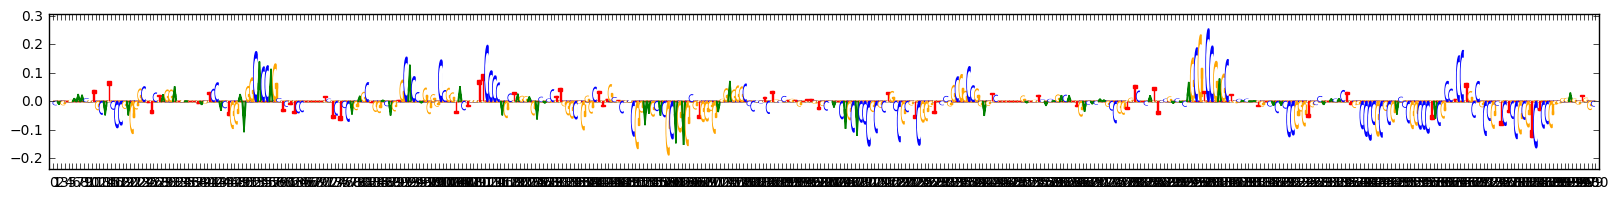

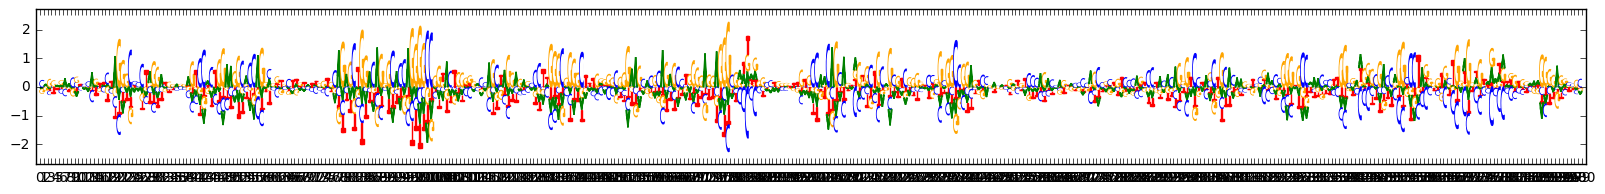

Example 1
Background reference scores:


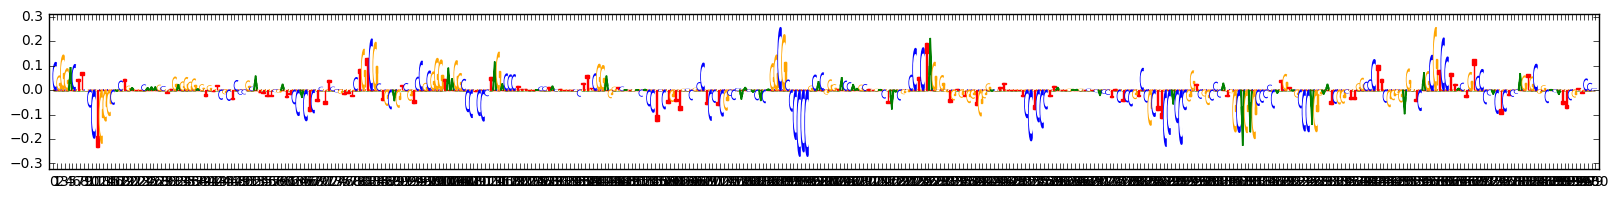

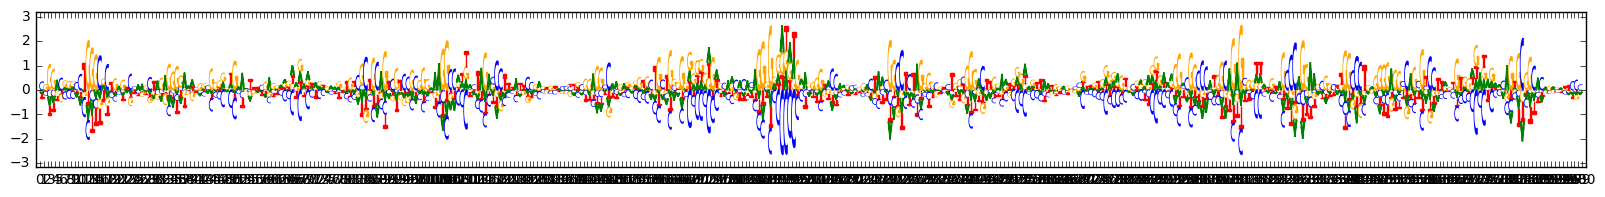

Example 2
Background reference scores:


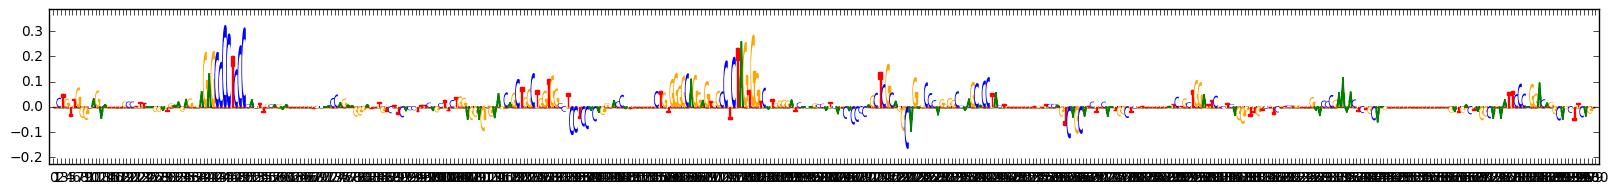

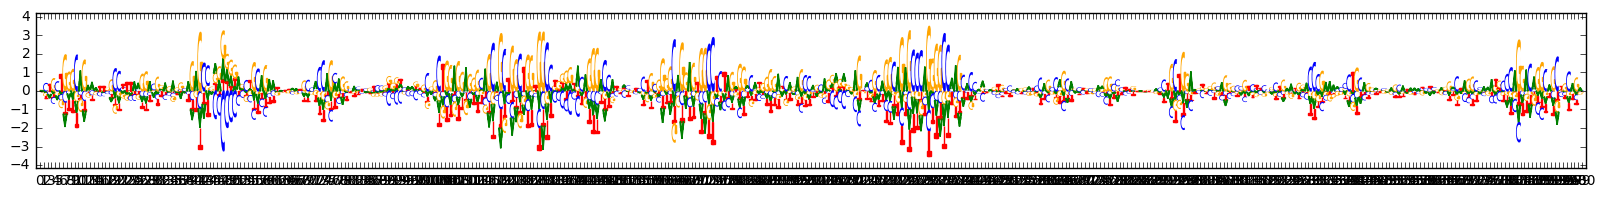

In [19]:
import ssvmimp.viz_sequence

for i,(bgref_scores_for_seq, bgref_hyp_scores_for_seq 
#       ,task1onlyref_scores_for_seq
#       ,task2onlyref_scores_for_seq
             ) in enumerate(zip(bgref_scores[:3],
                         bgref_hyp_scores[:3]
#                                                     ,task1onlyref_scores
#                                                     ,task2onlyref_scores
                                                    )):
    print("Example",i)
    print("Background reference scores:")
    ssvmimp.viz_sequence.plot_weights(bgref_scores_for_seq)
    ssvmimp.viz_sequence.plot_weights(bgref_hyp_scores_for_seq)
#    print("Scores with task1only example as reference:")
#    ssvmimp.viz_sequence.plot_weights(task1onlyref_scores_for_seq)
#    print("Scores with task2only example as reference:")
#    ssvmimp.viz_sequence.plot_weights(task2onlyref_scores_for_seq)

In [20]:
np.save("ctcf_importancescores_chr1.npy", bgref_scores)
np.save("ctcf_hypimpscores_chr1.npy",bgref_hyp_scores)